<a href="https://colab.research.google.com/github/AJ-21cm/AJ-21cm/blob/main/Real_Traffic_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
#import igraph as ig
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys
import os
py_file_location = "/content/drive/My Drive/MS_thesis_work/"
sys.path.append(os.path.abspath(py_file_location))

In [ ]:
import Graph_functions
import plotting_fun
import Queue_methods
import Stats_EE_recurr_cal

In [ ]:
def next_pos_Thrh_wSP_route(curr_node,destin_node,SP_route_dict):
  if curr_node<destin_node:
      route=SP_route_dict[(curr_node,destin_node)]
      route_=route.copy()
      #print(curr_node,destin_node,route_,"True")
  else:
      route=SP_route_dict[(destin_node,curr_node)]
      route_=route.copy()
      route_.reverse()
      #print(curr_node,destin_node,route_,"false")
  return route_[1]

In [ ]:
class Queue_array:
    def __init__(self):
        self.items = np.array([],dtype=int)
    def is_empty(self):
        return self.items ==np.array([])
    def enqueue(self, array_data):
        self.items=np.append(self.items,array_data,axis=0)
        return self.items
    def enqueue_sort(self, array_data):
        self.items=np.append(self.items,array_data,axis=0)
        self.items=np.sort(self.items)
        return  self.items
    def update_queue(self,value):
        self.items=np.round_(np.array(self.items,dtype=float)-value,1)
    def dequeue(self):
        self.items=np.delete(self.items,0,axis=0)
        return self.items
    def Count_Zeros(self):
        o_len=np.size(self.items)
        self.items=self.items[self.items!=0.0]
        n_zeros =o_len-np.size(self.items)
        return  n_zeros
    def show(self):
        return self.items
    def queue_size(self):
        return np.size(self.items)

In [ ]:
city_name="_NewYork_"
length_dict=plotting_fun.loadData("/content/drive/MyDrive/MS_thesis_work/SG_Edge_length"+city_name)
adjacency_list=plotting_fun.loadData("/content/drive/MyDrive/MS_thesis_work/adjacency_list"+city_name)
edges=Graph_functions.edges_from_adj_list(adjacency_list)
node_Degree_dict={i:len(adjacency_list[i]) for i in adjacency_list}
nodes=len(adjacency_list.keys())
filename="/content/drive/MyDrive/MS_thesis_work/SG_wSP"+city_name
SP_route_dict=plotting_fun.loadData(filename)
nodes,SP_route_dict

In [ ]:
length_dict

In [ ]:
double_edges=[(i[1],i[0]) for i in edges]
double_edges.extend(edges)

In [ ]:
Degrees=list(set(node_Degree_dict.values()))
Degrees

[1, 2, 3, 4, 5, 6]

In [ ]:
def Greenshield_model(vh,kj,k):
  return vh*(1-(k/kj))
def mod_Underwood_Expon_Model(vh,kj,k):
  if k<kj:
    return vh*np.exp(-k/kj)
  else:
    return 0

In [ ]:
node_capacity={}
n_1={}
prob_gen={}
lambdaa=0.02
for deg in Degrees:
  node_capacity[deg]=5*deg
  n_1[deg]=1
  prob_gen[deg]=0.9

In [ ]:
kj_dict={edge:10*(1+length_dict[edge]//25)for edge in edges}
plt.hist(kj_dict.values(),bins=50)

In [ ]:
Time=10
edge_info={i:{j:Queue_array() for j in range(nodes)} for i in double_edges}
Each_node_queue={i:Queue_array() for i in range(nodes)}
Each_node_edge_TimeS=np.zeros((nodes,nodes,Time))
for time in range(Time):
  for i in double_edges:
    for j in range(nodes):
        if edge_info[i][j].queue_size()!=0:
            edge_info[i][j].update_queue(0.1)
            Zeros=edge_info[i][j].Count_Zeros()
            if Zeros>0:
              if i[1]!=j:
                Each_node_queue[i[1]].enqueue([j for k in range(Zeros)])
              else:
                pass
                #print("Destination Reached")
            else:
              pass
              #print("Travelling")
        else:
          continue
  for node in range(nodes):
    rnum1=np.random.rand(1)[0]
    if rnum1<=prob_gen[node_Degree_dict[node]]: #and Each_node_queue[node].queue_size()<node_capacity[node_Degree_dict[node]]:
      create_particle=np.random.randint(0,nodes,1)[0]
      if create_particle!=node:
         Each_node_queue[node].enqueue([create_particle])
    #print("current node",node)
    #print("Current node queue at starting",Each_node_queue[node].show())
    #print("dummy",[[i,Each_node_queue_dummy[i].show()] for i in range(nodes)])
    q_s=Each_node_queue[node].queue_size()
    max_outf=n_1[node_Degree_dict[node]]
    if q_s>0:
          walker_out_dest=Each_node_queue[node].show()[0]
          choosen_node=next_pos_Thrh_wSP_route(node,walker_out_dest,SP_route_dict,length_dict)
          if node<choosen_node:
             density=np.sum([edge_info[(node,choosen_node)][i].queue_size() for i in range(nodes)])
             dens_max=kj_dict[(node,choosen_node)]
          else:
            density=np.sum([edge_info[(choosen_node,node)][i].queue_size() for i in range(nodes)])
            #density=np.sum([np.size(items) for items in l[(choosen_node,node)].items()])
            dens_max=kj_dict[(choosen_node,node)]
          speed=np.round(mod_Underwood_Expon_Model(80,dens_max,density),1)
          #print(f"speed:{speed} max_dens:{dens_max} dens:{density}")
          if speed!=0:
            if node<choosen_node:
              tt=np.round((length_dict[(node,choosen_node)])/speed ,1)
            else:
              tt=np.round((length_dict[(choosen_node,node)])/speed,1)
            edge_info[(node,choosen_node)][walker_out_dest].enqueue(np.array([tt],dtype=float))
            #print("choosen node",choosen_node)
            #print("walker is going on edge",(node,choosen_node),"time =",edge_info[(node,choosen_node)][walker_out_dest].show())
            Each_node_queue[node].dequeue()
          else:
            #print("Capacity reached")
            continue

    else:
      #print("Node %d is empty",node)
      continue
    #print("Current node queue after changes",Each_node_queue[node].show())
    #print("dummy",[[i,Each_node_queue_dummy[i].show()] for i in range(nodes)])
  node_visit={i:False for i in range(nodes)}
  for i in edges:
      Each_node_edge_TimeS[i[0],i[1],time]=np.sum([edge_info[(i[0],i[1])][k].queue_size() for k in range(nodes)])
      Each_node_edge_TimeS[i[1],i[0],time]=np.sum([edge_info[(i[1],i[0])][k].queue_size() for k in range(nodes)])
      if not node_visit[i[0]]:
        node_visit[i[0]]=True
        Each_node_edge_TimeS[i[0],i[0],time]=Each_node_queue[i[0]].queue_size()
      if not node_visit[i[1]]:
        node_visit[i[1]]=True
        Each_node_edge_TimeS[i[1],i[1],time]=Each_node_queue[i[1]].queue_size()

In [ ]:
Each_node_edge_TimeS[::,::,9]

array([[3., 1., 5., ..., 0., 0., 0.],
       [1., 2., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

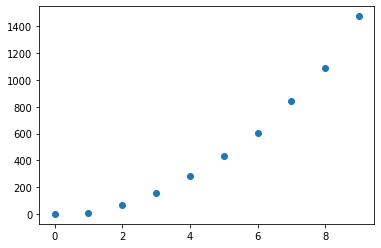

In [ ]:
nodes_arr=np.zeros(Time)
for i in range(nodes):
    nodes_arr+=Each_node_edge_TimeS[i,i,::]
plt.scatter(np.arange(Time),nodes_arr)

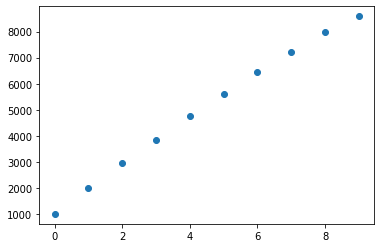

In [ ]:
edges_arr=np.zeros(Time)
for i in range(nodes):
  for j in range(i+1,nodes):
      edges_arr+=Each_node_edge_TimeS[i,j,::] + Each_node_edge_TimeS[j,i,::]
plt.scatter(np.arange(Time),edges_arr)

In [ ]:
Time=10
edge_info={i:{j:Queue_array() for j in range(nodes)} for i in double_edges}
Each_node_queue={i:Queue_array() for i in range(nodes)}
Each_node_edge_TimeS=np.zeros((nodes,nodes,Time))
for time in range(Time):
  for i in double_edges:
    node_qs=Each_node_queue[i[1]].queue_size()
    max_node_cap=node_capacity[node_Degree_dict[i[1]]]
    for j in range(nodes):
        if edge_info[i][j].queue_size()!=0:
            edge_info[i][j].update_queue(0.1)
            Zeros=edge_info[i][j].Count_Zeros()
            if Zeros>0 and abs(Zeros-node_qs)>=0:
              if i[1]!=j:
                Each_node_queue[i[1]].enqueue([j for k in range(Zeros)])
              else:
                pass
                #print("Destination Reached")
            else:
              pass
              #print("Travelling")
        else:
          continue
  for node in range(nodes):
    rnum1=np.random.rand(1)[0]
    if rnum1<=prob_gen[node_Degree_dict[node]]: #and Each_node_queue[node].queue_size()<node_capacity[node_Degree_dict[node]]:
      create_particle=np.random.randint(0,nodes,1)[0]
      if create_particle!=node:
         Each_node_queue[node].enqueue([create_particle])
    #print("current node",node)
    #print("Current node queue at starting",Each_node_queue[node].show())
    #print("dummy",[[i,Each_node_queue_dummy[i].show()] for i in range(nodes)])
    q_s=Each_node_queue[node].queue_size()
    max_outf=n_1[node_Degree_dict[node]]
    if q_s>0:
          walker_out_dest=Each_node_queue[node].show()[0]
          choosen_node=next_pos_Thrh_wSP_route(node,walker_out_dest,SP_route_dict,length_dict)
          if node<choosen_node:
             density=np.sum([edge_info[(node,choosen_node)][i].queue_size() for i in range(nodes)])
             dens_max=kj_dict[(node,choosen_node)]
          else:
            density=np.sum([edge_info[(choosen_node,node)][i].queue_size() for i in range(nodes)])
            #density=np.sum([np.size(items) for items in l[(choosen_node,node)].items()])
            dens_max=kj_dict[(choosen_node,node)]
          speed=np.round(mod_Underwood_Expon_Model(80,dens_max,density),1)
          #print(f"speed:{speed} max_dens:{dens_max} dens:{density}")
          if speed!=0:
            if node<choosen_node:
              tt=np.round((length_dict[(node,choosen_node)])/speed ,1)
            else:
              tt=np.round((length_dict[(choosen_node,node)])/speed,1)
            edge_info[(node,choosen_node)][walker_out_dest].enqueue(np.array([tt],dtype=float))
            #print("choosen node",choosen_node)
            #print("walker is going on edge",(node,choosen_node),"time =",edge_info[(node,choosen_node)][walker_out_dest].show())
            Each_node_queue[node].dequeue()
          else:
            #print("Capacity reached")
            continue

    else:
      #print("Node %d is empty",node)
      continue
    #print("Current node queue after changes",Each_node_queue[node].show())
    #print("dummy",[[i,Each_node_queue_dummy[i].show()] for i in range(nodes)])
  node_visit={i:False for i in range(nodes)}
  for i in edges:
      Each_node_edge_TimeS[i[0],i[1],time]=np.sum([edge_info[(i[0],i[1])][k].queue_size() for k in range(nodes)])
      Each_node_edge_TimeS[i[1],i[0],time]=np.sum([edge_info[(i[1],i[0])][k].queue_size() for k in range(nodes)])
      if not node_visit[i[0]]:
        node_visit[i[0]]=True
        Each_node_edge_TimeS[i[0],i[0],time]=Each_node_queue[i[0]].queue_size()
      if not node_visit[i[1]]:
        node_visit[i[1]]=True
        Each_node_edge_TimeS[i[1],i[1],time]=Each_node_queue[i[1]].queue_size()